In [20]:
import gymnasium as gym
from bettermdptools.utils.blackjack_wrapper import BlackjackWrapper
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.algorithms.planner import Planner
from bettermdptools.algorithms.rl import RL
import numpy as np
import matplotlib.pyplot as plt
from bettermdptools.utils.plots import Plots

In [21]:
# reward shape

def shape(env):
    env.reward_range = (-1000, 1000)
    for k in env.P.keys():
        v = env.P[k]
        for a in v.keys():
            p, s, r, t = v[a][0]
            new_reward = 1.0
            if t:
                if r == 0.0:
                    new_reward = -10.0
                else:
                    new_reward = 100.0

            env.P[k][a][0] = (p, s, new_reward, t)

def unshape(env):
    env.reward_range = (-1000, 1000)
    for k in env.P.keys():
        v = env.P[k]
        for a in v.keys():
            p, s, r, t = v[a][0]
            new_reward = 0.0
            if t:
                if r < 0.0:
                    new_reward = 0.0
                else:
                    new_reward = 1.0

            env.P[k][a][0] = (p, s, new_reward, t)

In [22]:
# helper

def iter_count(V_track, theta): # computes iterations to convergence
    index = 0
    max_diff = theta+1
    while (max_diff > theta):
        if (index == (len(V_track)-1)):
            print("reached iter cap")
            return
        v1 = V_track[index]
        v2 = V_track[index+1]
        max_diff = max([np.abs(v1[i]-v2[i]) for i in range(len(v1))])
        index += 1
    print("converged in", index, "iterations")
    return index

def diff_arr(V_track):
    diffs = []
    for i in range(len(V_track)-1):
        v1 = V_track[i]
        v2 = V_track[i+1]
        diff = max(abs(v1-v2))
        
        if (not np.any(v2)): # all zeroes
            break
        else:
            diffs.append(diff)
    return diffs

def q_diff(Q_track):
    diffs = []
    for ep in range(len(Q_track)-1):
        v1 = np.matrix(Q_track[ep])
        v2 = np.matrix(Q_track[ep+1])
        diff = np.max(np.abs(v1-v2))
        diffs.append(diff)
    return diffs

In [23]:
# test env
gym.envs.register(
    id="FrozenLake-v1",
    entry_point="gymnasium.envs.toy_text.frozen_lake:FrozenLakeEnv",
    max_episode_steps=500,      
)
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [128]:
# Lakes no hole no slip
lakes_nhns = [gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=5, p=1.0), 
                             is_slippery=False),
         gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=10, p=1.0), 
                             is_slippery=False),
         gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=20, p=1.0), 
                             is_slippery=False) 
        ]

In [130]:
# NO HOLE NO SLIP NO SHAPE

vi_diffs = []
pi_diffs = []
q_diffs = []

print("*** RUNNING VI *** ")

for frozen_lake in lakes_nhns:
    V, V_track, pi = Planner(frozen_lake.P).value_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    vi_diffs.append(diff_arr(V_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("VI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12) 
    
print("*** RUNNING PI *** ")

for frozen_lake in lakes_nhns:
    V, V_track, pi = Planner(frozen_lake.P).policy_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    pi_diffs.append(diff_arr(V_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("PI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12)

print("*** RUNNING QL *** ")

for frozen_lake in lakes_nhns:
    Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.5, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.9, n_episodes=10000)
    
    q_diffs.append(q_diff(Q_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("QL mean scores:", np.mean(test_scores))

*** RUNNING VI *** 
runtime = 0.00 seconds
VI mean scores: 1.0
converged in 9 iterations
runtime = 0.01 seconds
VI mean scores: 1.0
converged in 19 iterations
runtime = 0.06 seconds
VI mean scores: 1.0
converged in 39 iterations
*** RUNNING PI *** 
runtime = 0.00 seconds
PI mean scores: 1.0
converged in 9 iterations
runtime = 0.01 seconds
PI mean scores: 1.0
converged in 1 iterations
runtime = 0.08 seconds
PI mean scores: 1.0
converged in 40 iterations
*** RUNNING QL *** 


runtime = 1.58 seconds
QL mean scores: 1.0


runtime = 4.01 seconds
QL mean scores: 1.0


runtime = 61.53 seconds
QL mean scores: 0.0


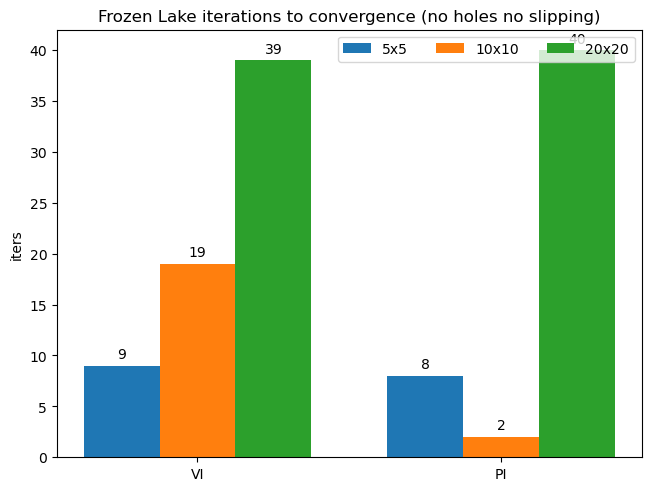

In [134]:
# Plot convergence no hole no slip no shaping

species = ("VI", "PI")
penguin_means = {
    '5x5': (9, 8),
    '10x10': (19, 2),
    '20x20': (39, 40),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('iters')
ax.set_title('Frozen Lake iterations to convergence (no holes no slipping)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper right', ncols=3)

plt.show()

In [ ]:
# Plot times no hole no slip no shaping

species = ("VI", "PI", "QL")
penguin_means = {
    '5x5': (.001, .001, 1.62),
    '10x10': (.001, .01, 4.03),
    '20x20': (.04, .06, 7.80),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time (seconds)')
ax.set_title('Frozen Lake training times (no holes no slipping)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)

plt.show()

In [112]:
# Q Learning
# no hol no slip large

Q, V, pi, Q_track, pi_track = RL(lakes_nhns[2]).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.5, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.9, n_episodes=10000)

q_diffs.append(q_diff(Q_track))

#test policy
test_scores = TestEnv.test_env(lakes_nhns[2], n_iters=100, render=False, pi=pi, user_input=False)
print("VI mean scores:", np.mean(test_scores))



runtime = 21.56 seconds
VI mean scores: 1.0


In [135]:
# NO HOLE NO SLIP with shaping

vi_diffs = []
pi_diffs = []
q_diffs = []

print("*** RUNNING VI *** ")

for frozen_lake in lakes_nhns:
    shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).value_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    vi_diffs.append(diff_arr(V_track))
    unshape(frozen_lake)
    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("VI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12) 
    
print("*** RUNNING PI *** ")

for frozen_lake in lakes_nhns:
    shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).policy_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    pi_diffs.append(diff_arr(V_track))

    unshape(frozen_lake)
    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("PI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12)

print("*** RUNNING QL *** ")

for frozen_lake in lakes_nhns:
    shape(frozen_lake)
    Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.5, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.9, n_episodes=10000)
    
    q_diffs.append(q_diff(Q_track))
    
    unshape(frozen_lake)
    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("QL mean scores:", np.mean(test_scores))

*** RUNNING VI *** 
runtime = 0.00 seconds
VI mean scores: 1.0
converged in 9 iterations
runtime = 0.01 seconds
VI mean scores: 1.0
converged in 19 iterations
runtime = 0.04 seconds
VI mean scores: 1.0
converged in 39 iterations
*** RUNNING PI *** 
runtime = 0.00 seconds
PI mean scores: 1.0
converged in 10 iterations
runtime = 0.01 seconds
PI mean scores: 1.0
converged in 20 iterations
runtime = 0.06 seconds
PI mean scores: 1.0
converged in 41 iterations
*** RUNNING QL *** 


runtime = 1.70 seconds
QL mean scores: 1.0


runtime = 3.98 seconds
QL mean scores: 1.0


runtime = 7.92 seconds
QL mean scores: 1.0


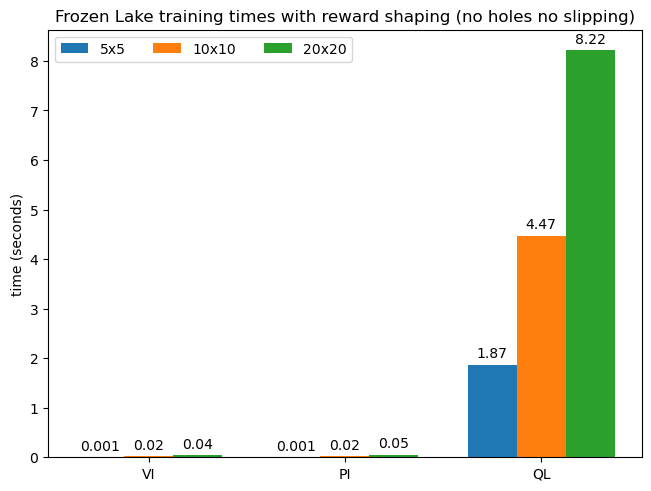

In [117]:

species = ("VI", "PI", "QL")
penguin_means = {
    '5x5': (.001, .001, 1.87),
    '10x10': (.02, .02, 4.47),
    '20x20': (.04, .05, 8.22),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time (seconds)')
ax.set_title('Frozen Lake training times with reward shaping (no holes no slipping)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)

plt.show()

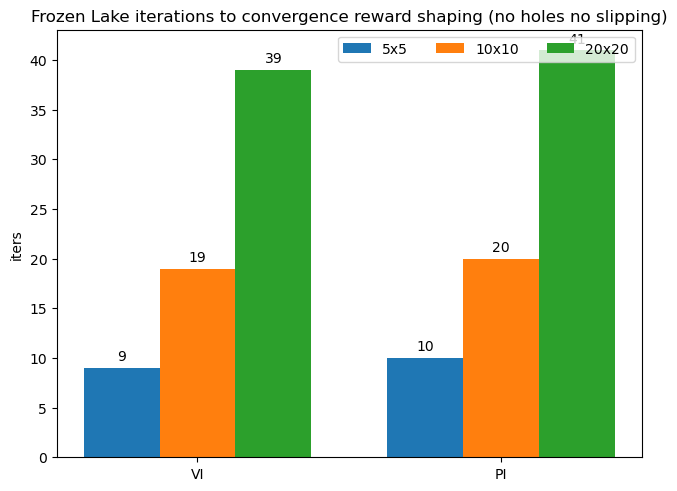

In [136]:
# Plot convergence no hole no slip with shaping

species = ("VI", "PI")
penguin_means = {
    '5x5': (9, 10),
    '10x10': (19, 20),
    '20x20': (39, 41),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('iters')
ax.set_title('Frozen Lake iterations to convergence reward shaping (no holes no slipping)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper right', ncols=3)

plt.show()

In [147]:
# Lakes with holes no slip
lakes_whns = [gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=5, p=.7), 
                             is_slippery=False),
         gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=10, p=.8), 
                             is_slippery=False),
         gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=20, p=.9), 
                             is_slippery=False) 
        ]

In [150]:
# WITH HOLE NO SLIP no shaping

vi_diffs = []
pi_diffs = []
q_diffs = []

print("*** RUNNING VI *** ")

for frozen_lake in lakes_whns:
    shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).value_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    vi_diffs.append(diff_arr(V_track))
    unshape(frozen_lake)
    
    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("VI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12) 
    
print("*** RUNNING PI *** ")

for frozen_lake in lakes_whns:
    shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).policy_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    pi_diffs.append(diff_arr(V_track))

    unshape(frozen_lake)

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("PI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12)

print("*** RUNNING QL *** ")

for frozen_lake in lakes_whns:
    shape(frozen_lake)
    Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.9, 
        init_epsilon=1.0, min_epsilon=0.001, epsilon_decay_ratio=0.995, n_episodes=10000)
    
    q_diffs.append(q_diff(Q_track))
    
    unshape(frozen_lake)
    
    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("QL mean scores:", np.mean(test_scores))

*** RUNNING VI *** 
runtime = 0.00 seconds
VI mean scores: 1.0
converged in 9 iterations
runtime = 0.01 seconds
VI mean scores: 1.0
converged in 19 iterations
runtime = 0.05 seconds
VI mean scores: 1.0
converged in 39 iterations
*** RUNNING PI *** 
runtime = 0.04 seconds
PI mean scores: 1.0
converged in 11 iterations
runtime = 0.01 seconds
PI mean scores: 1.0
converged in 14 iterations
runtime = 0.69 seconds
PI mean scores: 1.0
converged in 31 iterations
*** RUNNING QL *** 


runtime = 1.41 seconds
QL mean scores: 1.0


runtime = 31.47 seconds
QL mean scores: 0.0


runtime = 13.36 seconds
QL mean scores: 0.0


In [20]:
# Lakes no hole with slips
lakes_nhws = [gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=5, p=1.0), 
                             is_slippery=True),
         gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=10, p=1.0), 
                             is_slippery=True),
         gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=20, p=1.0), 
                             is_slippery=True) 
        ]

In [21]:
# NO HOLES WITH SLIP NO SHAPE

vi_diffs = []
pi_diffs = []
q_diffs = []

print("*** RUNNING VI *** ")

for frozen_lake in lakes_nhws:
    V, V_track, pi = Planner(frozen_lake.P).value_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    vi_diffs.append(diff_arr(V_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("VI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12) 
    
print("*** RUNNING PI *** ")

for frozen_lake in lakes_nhws:
    V, V_track, pi = Planner(frozen_lake.P).policy_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    pi_diffs.append(diff_arr(V_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("PI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12)

print("*** RUNNING QL *** ")

for frozen_lake in lakes_nhws:
    Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.5, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.9, n_episodes=10000)
    
    q_diffs.append(q_diff(Q_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("QL mean scores:", np.mean(test_scores))

*** RUNNING VI *** 
runtime = 0.06 seconds
VI mean scores: 1.0
converged in 277 iterations
runtime = 0.27 seconds
VI mean scores: 1.0
converged in 367 iterations
runtime = 1.25 seconds
VI mean scores: 1.0
converged in 452 iterations
*** RUNNING PI *** 
runtime = 0.05 seconds
PI mean scores: 1.0
converged in 1 iterations
runtime = 0.45 seconds
PI mean scores: 1.0
converged in 6 iterations
runtime = 2.32 seconds
PI mean scores: 1.0
converged in 8 iterations
*** RUNNING QL *** 


runtime = 4.95 seconds
QL mean scores: 1.0


runtime = 12.00 seconds
QL mean scores: 1.0


runtime = 24.29 seconds
QL mean scores: 1.0


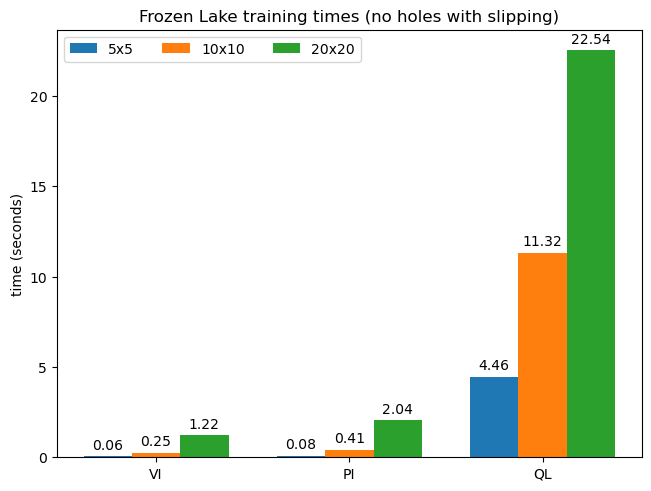

In [123]:

species = ("VI", "PI", "QL")
penguin_means = {
    '5x5': (277, .08, 4.46),
    '10x10': (367, .41, 11.32),
    '20x20': (1.22, 2.04, 22.54),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time (seconds)')
ax.set_title('Frozen Lake training times (no holes with slipping)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)

plt.show()

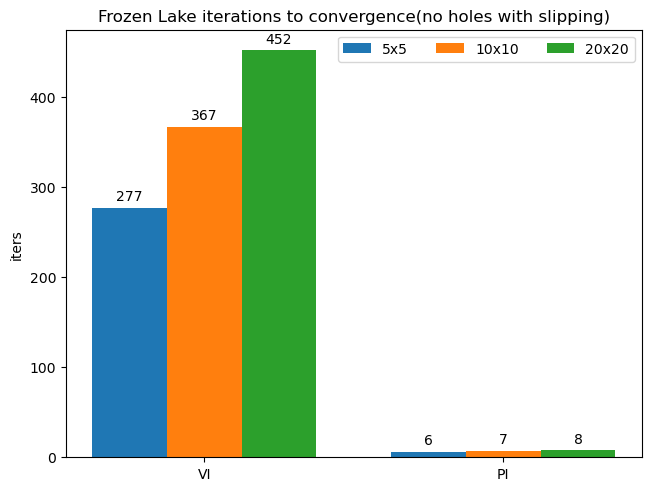

In [139]:
# Plot convergence no hole with slips no shaping

species = ("VI", "PI")
penguin_means = {
    '5x5': (277, 6),
    '10x10': (367, 7),
    '20x20': (452, 8),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('iters')
ax.set_title('Frozen Lake iterations to convergence(no holes with slipping)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper right', ncols=3)

plt.show()

In [22]:
# NO HOLES WITH SLIP REWARD SHAPING

vi_diffs = []
pi_diffs = []
q_diffs = []

print("*** RUNNING VI *** ")

for frozen_lake in lakes_nhws:
    shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).value_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    vi_diffs.append(diff_arr(V_track))
    
    unshape(frozen_lake)
    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("VI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12) 
    
print("*** RUNNING PI *** ")

for frozen_lake in lakes_nhws:
    shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).policy_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    unshape(frozen_lake)
    
    pi_diffs.append(diff_arr(V_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("PI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12)

print("*** RUNNING QL *** ")

for frozen_lake in lakes_nhws:
    shape(frozen_lake)
    Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.5, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.9, n_episodes=10000)
    
    unshape(frozen_lake)
    q_diffs.append(q_diff(Q_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("QL mean scores:", np.mean(test_scores))

*** RUNNING VI *** 
runtime = 0.08 seconds
VI mean scores: 1.0
converged in 388 iterations
runtime = 0.34 seconds
VI mean scores: 1.0
converged in 473 iterations
runtime = 1.64 seconds
VI mean scores: 1.0
converged in 546 iterations
*** RUNNING PI *** 
runtime = 0.06 seconds
PI mean scores: 1.0
converged in 6 iterations
runtime = 0.58 seconds
PI mean scores: 1.0
converged in 7 iterations
runtime = 4.68 seconds
PI mean scores: 1.0
converged in 27 iterations
*** RUNNING QL *** 


runtime = 4.81 seconds
QL mean scores: 1.0


runtime = 11.81 seconds
QL mean scores: 1.0


runtime = 25.68 seconds
QL mean scores: 1.0


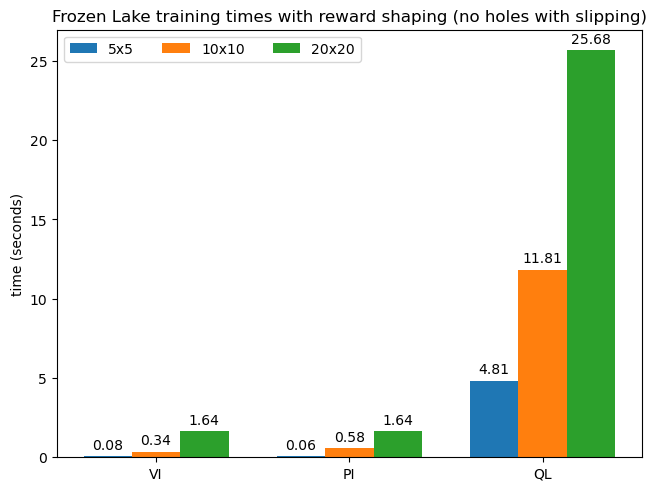

In [23]:
# Plot no hole with slip shaping
species = ("VI", "PI", "QL")
penguin_means = {
    '5x5': (.08, .06, 4.81),
    '10x10': (.34, .58, 11.81),
    '20x20': (1.64, 1.64, 25.68),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time (seconds)')
ax.set_title('Frozen Lake training times with reward shaping (no holes with slipping)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)

plt.show()

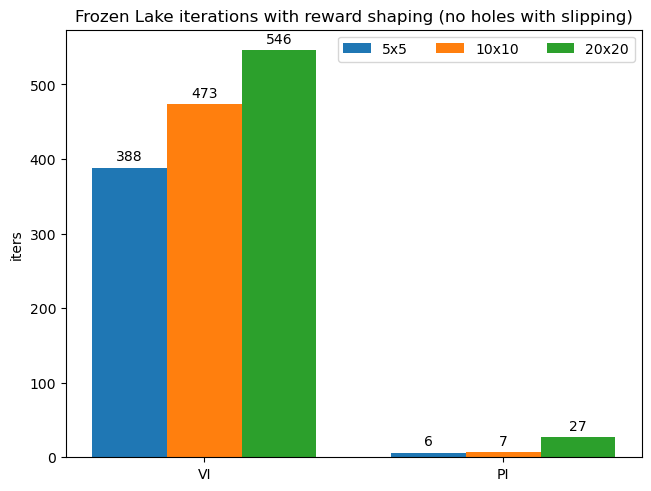

In [25]:
# Plot iters no hole with slips no shaping



species = ("VI", "PI")
penguin_means = {
    '5x5': (388, 6),
    '10x10': (473, 7),
    '20x20': (546, 27),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('iters')
ax.set_title('Frozen Lake iterations with reward shaping (no holes with slipping)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper right', ncols=3)

plt.show()

In [20]:
# run PI

pi_diffs = []

for frozen_lake in lakes_nh:
    V, V_track, pi = Planner(frozen_lake.P).policy_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    pi_diffs.append(diff_arr(V_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("VI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12)

runtime = 0.20 seconds
VI mean scores: 1.0
converged in 5 iterations
runtime = 1.24 seconds
VI mean scores: 1.0
converged in 7 iterations
runtime = 7.09 seconds
VI mean scores: 1.0
converged in 8 iterations


In [22]:
q_diffs = []

In [23]:
# Q Learning
# small

Q, V, pi, Q_track, pi_track = RL(lakes_nh[0]).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.5, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.9, n_episodes=10000)

q_diffs.append(q_diff(Q_track))

#test policy
test_scores = TestEnv.test_env(env=lakes_nh[0], n_iters=100, render=False, pi=pi, user_input=False)
print("VI mean scores:", np.mean(test_scores))


runtime = 11.94 seconds
VI mean scores: 1.0


In [24]:
# Q Learning
# med

Q, V, pi, Q_track, pi_track = RL(lakes_nh[1]).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.5, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.9, n_episodes=10000)

q_diffs.append(q_diff(Q_track))

#test policy
test_scores = TestEnv.test_env(env=lakes_nh[1], n_iters=100, render=False, pi=pi, user_input=False)
print("VI mean scores:", np.mean(test_scores))


runtime = 32.21 seconds
VI mean scores: 1.0


In [25]:
# Q Learning
# large

Q, V, pi, Q_track, pi_track = RL(lakes_nh[2]).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.5, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.9, n_episodes=10000)

q_diffs.append(q_diff(Q_track))

#test policy
test_scores = TestEnv.test_env(env=lakes_nh[2], n_iters=100, render=False, pi=pi, user_input=False)
print("VI mean scores:", np.mean(test_scores))


runtime = 62.46 seconds
VI mean scores: 1.0


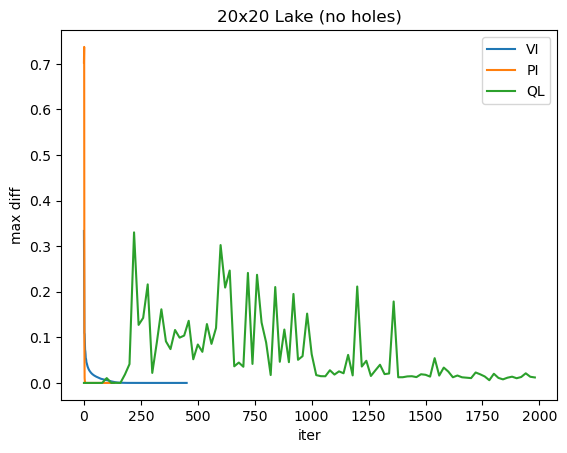

In [58]:
# Plots no holes learning curves

q_diffs_m = [q_diffs[2][:2000][i] for i in range(0, len(q_diffs[2][:2000]),20)]
q_x = [x for x in range(0, len(q_diffs[2][:2000]),20)]

fig, ax = plt.subplots()
ax.set_title("20x20 Lake (no holes)")
ax.set_xlabel("iter")
ax.set_ylabel("max diff")
ax.plot(vi_diffs[2],label="VI")
ax.plot(pi_diffs[2],label="PI")
ax.plot(q_x, q_diffs_m,label="QL")
ax.legend(loc="upper right")


In [102]:
# Lakes with holes


lakes_h = [gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=5, p=.7), 
                             is_slippery=True),
         gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=10, p=.8), 
                             is_slippery=True),
         gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=20, p=.9), 
                             is_slippery=True) 
        ]


In [84]:
# run VI

vi_diffs_h = []

for frozen_lake in lakes_h:
    shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).value_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    vi_diffs_h.append(diff_arr(V_track))
    unshape(frozen_lake)

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("VI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12)

runtime = 0.28 seconds
VI mean scores: 0.98
converged in 583 iterations
runtime = 1.63 seconds
VI mean scores: 0.96
converged in 971 iterations
runtime = 10.17 seconds
VI mean scores: 0.97
converged in 1487 iterations


In [103]:
# run PI

pi_diffs_h = []

for frozen_lake in lakes_h:
    shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).policy_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    pi_diffs_h.append(diff_arr(V_track))

    unshape(frozen_lake)
    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("PI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12)

runtime = 0.20 seconds
PI mean scores: 1.0
converged in 7 iterations
runtime = 1.71 seconds
PI mean scores: 0.04
converged in 9 iterations
runtime = 9.90 seconds
PI mean scores: 0.89
converged in 9 iterations


In [95]:
# Q Learning
# small

lake = lakes_h[0]
shape(lake)

Q, V, pi, Q_track, pi_track = RL(lake).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.5, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.9, n_episodes=10000)

q_diffs_s = q_diff(Q_track)

unshape(lake)

#test policy
test_scores = TestEnv.test_env(env=lake, n_iters=100, render=False, pi=pi, user_input=False)
print("VI mean scores:", np.mean(test_scores))

runtime = 9.12 seconds
VI mean scores: 0.06


In [97]:
# Q Learning
# medium

shape(lakes_h[1])

Q, V, pi, Q_track, pi_track = RL(lakes_h[1]).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.9, 
        init_epsilon=1.0, min_epsilon=0.001, epsilon_decay_ratio=0.95, n_episodes=20000)
q_diffs_m = q_diff(Q_track)

unshape(lakes_h[1])

#test policy
test_scores = TestEnv.test_env(env=lakes_h[1], n_iters=100, render=False, pi=pi, user_input=False)
print("QL mean scores:", np.mean(test_scores))

runtime = 3.08 seconds
QL mean scores: 0.0


In [90]:
# Q Learning

# large

shape(lakes_h[2])

Q, V, pi, Q_track, pi_track = RL(lakes_h[2]).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.5, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.9, n_episodes=10000)

q_diffs_l = q_diff(Q_track)

unshape(lakes_h[2])

#test policy
test_scores = TestEnv.test_env(env=lakes_h[2], n_iters=100, render=False, pi=pi, user_input=False)
print("VI mean scores:", np.mean(test_scores))

runtime = 5.27 seconds
VI mean scores: 1.0


In [14]:
# NO HOLES WITH SLIP NO REWARD SHAPING

vi_diffs = []
pi_diffs = []
q_diffs = []

print("*** RUNNING VI *** ")

for frozen_lake in lakes_h8:
    V, V_track, pi = Planner(frozen_lake.P).value_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    vi_diffs.append(diff_arr(V_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("VI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12) 
    
print("*** RUNNING PI *** ")

for frozen_lake in lakes_h8:
    V, V_track, pi = Planner(frozen_lake.P).policy_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    pi_diffs.append(diff_arr(V_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("PI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12)

print("*** RUNNING QL *** ")

for frozen_lake in lakes_h8:
    Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.5, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.9, n_episodes=10000)
    
    q_diffs.append(q_diff(Q_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("QL mean scores:", np.mean(test_scores))

*** RUNNING VI *** 
runtime = 0.01 seconds
VI mean scores: 1.0
converged in 22 iterations
runtime = 0.00 seconds
VI mean scores: 1.0
converged in 15 iterations
runtime = 0.00 seconds
VI mean scores: 1.0
converged in 15 iterations
runtime = 0.00 seconds
VI mean scores: 1.0
converged in 15 iterations
*** RUNNING PI *** 
runtime = 0.02 seconds
PI mean scores: 1.0
converged in 1 iterations
runtime = 0.02 seconds
PI mean scores: 1.0
converged in 16 iterations
runtime = 0.00 seconds
PI mean scores: 1.0
converged in 15 iterations
runtime = 0.00 seconds
PI mean scores: 1.0
converged in 16 iterations
*** RUNNING QL *** 


runtime = 31.26 seconds
QL mean scores: 0.0


runtime = 25.14 seconds
QL mean scores: 0.0


runtime = 47.18 seconds
QL mean scores: 0.0


runtime = 23.25 seconds
QL mean scores: 0.0


In [35]:
# SLIPPING HOLES 
lakes_whws = [gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=5, p=.9), 
                             is_slippery=True),
              gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=10, p=.9), 
                             is_slippery=True),
              gym.make("FrozenLake-v1", 
                             desc=generate_random_map(size=20, p=.9), 
                             is_slippery=True),
        ]

In [ ]:
# SLIPPING HOLES NO SHAPING

vi_diffs = []
pi_diffs = []
q_diffs = []

print("*** RUNNING VI *** ")

for frozen_lake in lakes_whws:
    #shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).value_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    
    vi_diffs.append(diff_arr(V_track))
    
    #unshape(frozen_lake)
    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=1000, render=False, pi=pi, user_input=False)
    print("VI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12) 
    
print("*** RUNNING PI *** ")

for frozen_lake in lakes_whws:
    #shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).policy_iteration(
    gamma=.99, n_iters=10000, theta=1e-12)
    #unshape(frozen_lake)
    
    pi_diffs.append(diff_arr(V_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=1000, render=False, pi=pi, user_input=False)
    print("PI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12)

print("*** RUNNING QL *** ")

for frozen_lake in lakes_whws:
    #shape(frozen_lake)
    Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(
        gamma=.9, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.9, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.995, n_episodes=10000)
    
   # unshape(frozen_lake)
    q_diffs.append(q_diff(Q_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=1000, render=False, pi=pi, user_input=False)
    print("QL mean scores:", np.mean(test_scores))

*** RUNNING VI *** 
runtime = 0.13 seconds
VI mean scores: 1.0
converged in 630 iterations
runtime = 0.30 seconds
VI mean scores: 0.941
converged in 443 iterations
runtime = 2.33 seconds
VI mean scores: 0.881
converged in 898 iterations
*** RUNNING PI *** 
runtime = 0.09 seconds
PI mean scores: 1.0
converged in 6 iterations
runtime = 0.32 seconds
PI mean scores: 0.951
converged in 5 iterations
runtime = 2.04 seconds
PI mean scores: 0.897
converged in 6 iterations
*** RUNNING QL *** 


runtime = 3.96 seconds
QL mean scores: 0.613


 78%|██████████████████████████████████████████████████████████▌                | 7808/10000 [00:10<00:07, 292.97it/s]

In [ ]:
*** RUNNING VI *** 
runtime = 0.08 seconds
VI mean scores: 1.0
converged in 368 iterations
runtime = 0.33 seconds
VI mean scores: 1.0
converged in 521 iterations
runtime = 1.74 seconds
VI mean scores: 0.95
converged in 706 iterations
*** RUNNING PI *** 
runtime = 0.07 seconds
PI mean scores: 1.0
converged in 6 iterations
runtime = 0.75 seconds
PI mean scores: 1.0
converged in 14 iterations
runtime = 2.25 seconds
PI mean scores: 0.95
converged in 9 iterations
*** RUNNING QL *** 
runtime = 15.08 seconds
QL mean scores: 1.0
runtime = 41.36 seconds
QL mean scores: 0.81

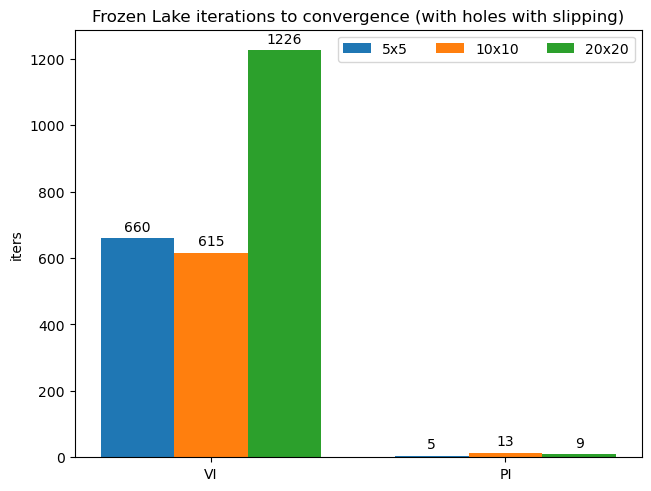

In [19]:

# Plot convergence with holes with slip 

species = ("VI", "PI")
penguin_means = {
    '5x5': (660, 5),
    '10x10': (615, 13),
    '20x20': (1226, 9),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('iters')
ax.set_title('Frozen Lake iterations to convergence (with holes with slipping)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper right', ncols=3)

plt.show()

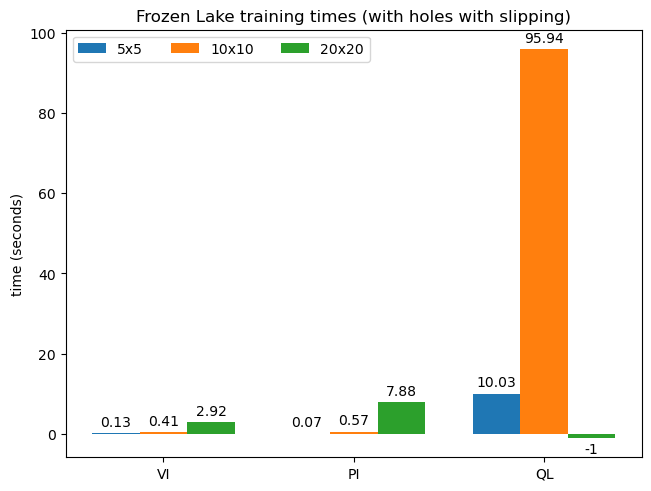

In [15]:
# TIMES PLOT WITH HOLE WITH SLIP
species = ("VI", "PI", "QL")
penguin_means = {
    '5x5': (.13, .07, 10.03),
    '10x10': (.41, .57, 95.94),
    '20x20': (2.92, 7.88, -1),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time (seconds)')
ax.set_title('Frozen Lake training times (with holes with slipping)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)

plt.show()

In [ ]:
[]

In [33]:
# SLIPPING HOLES  REWARD SHAPING

vi_diffs = []
pi_diffs = []
q_diffs = []

print("*** RUNNING VI *** ")

for frozen_lake in lakes_whws:
    shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).value_iteration(
    gamma=.9, n_iters=10000, theta=1e-12)
    
    vi_diffs.append(diff_arr(V_track))
    
    unshape(frozen_lake)
    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("VI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12) 
    
print("*** RUNNING PI *** ")

for frozen_lake in lakes_whws:
    shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).policy_iteration(
    gamma=.9, n_iters=10000, theta=1e-12)
    unshape(frozen_lake)
    
    pi_diffs.append(diff_arr(V_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("PI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12)

print("*** RUNNING QL *** ")

for frozen_lake in lakes_whws:
    shape(frozen_lake)
    Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(
        gamma=.8, init_alpha=0.6, min_alpha=0.1, alpha_decay_ratio=0.99, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.995, n_episodes=100000)
    
    unshape(frozen_lake)
    q_diffs.append(q_diff(Q_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("QL mean scores:", np.mean(test_scores))

*** RUNNING VI *** 
runtime = 0.03 seconds
VI mean scores: 0.72
converged in 184 iterations
runtime = 0.16 seconds
VI mean scores: 1.0
converged in 217 iterations
runtime = 0.61 seconds
VI mean scores: 0.94
converged in 255 iterations
*** RUNNING PI *** 
runtime = 0.03 seconds
PI mean scores: 0.64
converged in 6 iterations
runtime = 0.16 seconds
PI mean scores: 1.0
converged in 8 iterations
runtime = 0.89 seconds
PI mean scores: 0.9
converged in 10 iterations
*** RUNNING QL *** 


runtime = 31.07 seconds
QL mean scores: 0.68


KeyboardInterrupt: 

In [62]:
for frozen_lake in lakes_whws:
    shape(frozen_lake)
    Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.9, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.99, n_episodes=10000)
    
    unshape(frozen_lake)
    q_diffs.append(q_diff(Q_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("QL mean scores:", np.mean(test_scores))

runtime = 6.02 seconds
QL mean scores: 1.0


runtime = 14.98 seconds
QL mean scores: 0.41


runtime = 24.85 seconds
QL mean scores: 0.0


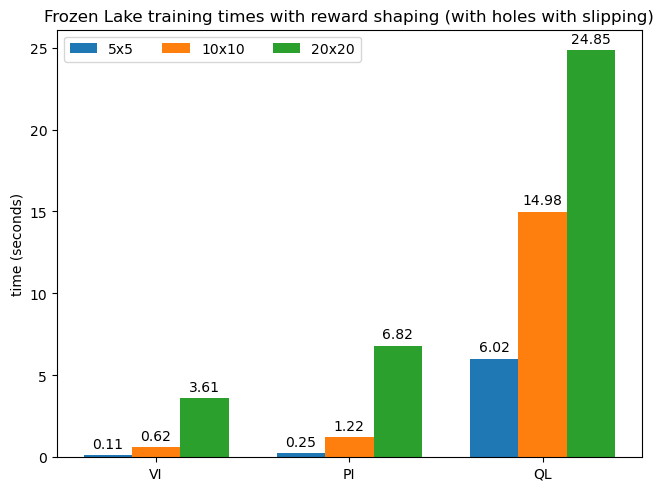

In [63]:
# TIMES PLOT WITH HOLE WITH SLIP
species = ("VI", "PI", "QL")
penguin_means = {
    '5x5': (.11, .25, 6.02),
    '10x10': (.62, 1.22, 14.98),
    '20x20': (3.61, 6.82, 24.85),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time (seconds)')
ax.set_title('Frozen Lake training times with reward shaping (with holes with slipping)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)

plt.show()

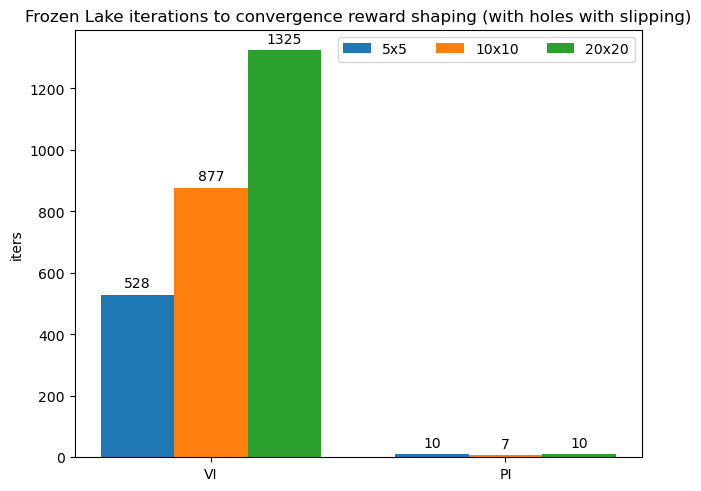

In [64]:

# Plot convergence with holes with slip with shaping

species = ("VI", "PI")
penguin_means = {
    '5x5': (528, 10),
    '10x10': (877, 7),
    '20x20': (1325, 10),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('iters')
ax.set_title('Frozen Lake iterations to convergence reward shaping (with holes with slipping)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper right', ncols=3)

plt.show()

In [ ]:
# SLIPPING HOLES  REWARD SHAPING

vi_diffs = []
pi_diffs = []
q_diffs = []

print("*** RUNNING VI *** ")

for frozen_lake in lakes_whws:
    shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).value_iteration(
    gamma=.9, n_iters=10000, theta=1e-12)
    
    vi_diffs.append(diff_arr(V_track))
    
    unshape(frozen_lake)
    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("VI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12) 
    
print("*** RUNNING PI *** ")

for frozen_lake in lakes_whws:
    shape(frozen_lake)
    V, V_track, pi = Planner(frozen_lake.P).policy_iteration(
    gamma=.9, n_iters=10000, theta=1e-12)
    unshape(frozen_lake)
    
    pi_diffs.append(diff_arr(V_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("PI mean scores:", np.mean(test_scores))
    iter_count(V_track, 1e-12)

print("*** RUNNING QL *** ")

for frozen_lake in lakes_whws:
    shape(frozen_lake)
    Q, V, pi, Q_track, pi_track = RL(frozen_lake).q_learning(
        gamma=.9, init_alpha=0.5, min_alpha=0.1, alpha_decay_ratio=0.9, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.99, n_episodes=10000)
    
    unshape(frozen_lake)
    q_diffs.append(q_diff(Q_track))

    #test policy
    test_scores = TestEnv.test_env(env=frozen_lake, n_iters=100, render=False, pi=pi, user_input=False)
    print("QL mean scores:", np.mean(test_scores))